# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>


## PyTorch и полносвязные нейронные сети

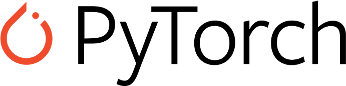

Обучение нейронной сети заключается в минимизации некоторой функции потерь, зависящей от значений активации нейронов. Так как мы знаем весь процесс построения этой функции, то для минимизации нам достоточно посчитать градиент от всех параметров функции (нейронов) и затем двигаться по нему, обновляя значения параметров. Однако современные нейронные сети могут содержать в себе миллиарды параметров (например, GPT-3 содержит 175 миллиардов, а гугловская PaLM 540 миллиардов!), что делает вычисление градиента вручную невозможным. К счастью, люди придумали как автоматизировать этот процесс с помощью вычислительного графа, и написали библиотеки (Keras, TensorFlow, PyTorch), которые занимаются этим за нас :)

PyTorch - это один из фреймфорков для задач глубокого обучения, то есть библиотека, позволяющая:
* Производить быстрые матричные вычисления с использованием видеопамяти
* Строить вычислителный граф и дифференцировать его (то есть сможем получать градиент функции потерь)

In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
import torch.nn.functional as F

print(torch.__version__)

2.4.1


# Torch Tensor

Основным объектом, с которым оперирует PyTorch, является `torch.tensor`. Он представляет собой многомерную матрицу с элементами одного типа данных. Работа с тензорами в PyTorch похожа на работу с массивами в `numpy`. Посмотрим на некоторые методы `torch.tensor`

### Инициализация

Тензор можно создать из списка, кортежа, массива numpy или просто числа

In [2]:
print(torch.tensor([1, 2, 3]), 'тензор из списка')
print(torch.tensor((1, 2, 3)), 'тензор из кортежа')
print(torch.tensor(np.array([1, 2, 3])), 'тензор из массива numpy')
print(torch.tensor((1)), 'тензор из числа')

tensor([1, 2, 3]) тензор из списка
tensor([1, 2, 3]) тензор из кортежа
tensor([1, 2, 3], dtype=torch.int32) тензор из массива numpy
tensor(1) тензор из числа


Так же, как и в `numpy`, тензор может быть создан произвольного размера. Узнать размер тензора можно вызвав метод `size()` или посмотрев атрибут `shape`.

In [3]:
t = torch.tensor([[1, 2, 3], [2, 3, 4]])

print(t)
print(t.size(), 'метод `size()`')
print(t.shape, 'атрибут shape')

tensor([[1, 2, 3],
        [2, 3, 4]])
torch.Size([2, 3]) метод `size()`
torch.Size([2, 3]) атрибут shape


Можно конкретизировать тип данных с помощью аргумент `dtype`.

In [4]:
t = torch.tensor([[1, 2, 3], [2, 3, 4]], dtype=torch.float64)
print(t)

tensor([[1., 2., 3.],
        [2., 3., 4.]], dtype=torch.float64)


Аналогично `numpy` есть методы создания матриц, заполненных нулями и единицами: `zeros()`, `ones()`.

### Математические операции

Над тензорами можно производить математические операции, так же как и в `numpy`. Например складывать с числом и умножать на число

In [5]:
a = torch.ones((2, 3))

print(a, 'изначальный тензор A\n')

print(a + 1, 'A + 1\n')

print(a * 3, 'A * 3\n')

tensor([[1., 1., 1.],
        [1., 1., 1.]]) изначальный тензор A

tensor([[2., 2., 2.],
        [2., 2., 2.]]) A + 1

tensor([[3., 3., 3.],
        [3., 3., 3.]]) A * 3



Складывать и умножать два тезора (поэлементно)

In [6]:
a = torch.ones((2, 3))
b = torch.full((2, 3), 8)

print(f'A = {a}\n\nB = {b}\n\nA + B = {a + b}\n\nA * B = {a * b}')

A = tensor([[1., 1., 1.],
        [1., 1., 1.]])

B = tensor([[8, 8, 8],
        [8, 8, 8]])

A + B = tensor([[9., 9., 9.],
        [9., 9., 9.]])

A * B = tensor([[8., 8., 8.],
        [8., 8., 8.]])


Умножать тензоры матрично

In [7]:
a = torch.ones((2, 3))
b = torch.full((3, 2), 8.)


print(f'A = {a}\n\nB = {b}\n\nA @ B = {a @ b}')

A = tensor([[1., 1., 1.],
        [1., 1., 1.]])

B = tensor([[8., 8.],
        [8., 8.],
        [8., 8.]])

A @ B = tensor([[24., 24.],
        [24., 24.]])


Применять агрегирующие функции

In [8]:
a = torch.ones((4, 3))


print(a, 'Тензор A\n')
print(f'Усреденение по столбцам A  = {a.mean(dim=0)}\n')
print(f'Сумма по строчкам A  = {a.sum(dim=1)}\n')
print(f'Кумулятивная сумма по столбцам A:\n{a.cumsum(dim=0)}')

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]) Тензор A

Усреденение по столбцам A  = tensor([1., 1., 1.])

Сумма по строчкам A  = tensor([3., 3., 3., 3.])

Кумулятивная сумма по столбцам A:
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]])


### Переход от `torch.tensor` к `numpy.ndarray`

Если вам требуется перевести тензор в массив numpy, то сделать это можно вызовом метода `numpy()`

In [9]:
t = torch.ones((2, 3))

print(type(t), 't - тензор\n')
print(type(t.numpy()), 't стал массивом numpy')

<class 'torch.Tensor'> t - тензор

<class 'numpy.ndarray'> t стал массивом numpy


**ЗАДАЧА 1**

Пользуясь функциями `torch.tensor` создайте **один** тензор, и посчитайте с его помощью сумму чисел от 1 до 100. Затем посчитайте суммы чисел в каждом десятке (от 1 до 10, от 11 до 20 и так далее)

In [10]:
one_tensor = torch.tensor(np.array([np.array([i for i in range(1, 11)]) + (10 * j) for j in range(0, 10)]))

In [11]:
one_tensor

tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
        [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
        [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
        [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
        [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
        [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
        [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
        [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]], dtype=torch.int32)

In [12]:
one_tensor.sum(axis=1)

tensor([ 55, 155, 255, 355, 455, 555, 655, 755, 855, 955])

In [13]:
one_tensor.sum()

tensor(5050)

Все же некоторые названия методов отличаются от `numpy`-евских. Полной совместимости с `numpy` пока нет, но от версии к версии разрыв сокращается, и придется снова запоминать новые названия для некоторых методов.

Например, PyTorch имеет другое написание стандартных типов
 * `x.astype('int64') -> x.type(torch.LongTensor)`


Для более подробного ознакомления можно посмотреть на <a href="https://github.com/torch/torch7/wiki/Torch-for-Numpy-users" target="_blank">табличку</a> перевода методов из `numpy` в `torch`, а также заглянуть в <a href="http://pytorch.org/docs/master/" target="_blank">документацию</a>. Также при возникновении проблем часто помогает зайти на <a href="https://discuss.pytorch.org/" target="_blank">pytorch forums</a>. Можете также глянуть эту <a href="https://qudata.com/ml/ru/NN_Base_Torch.html" target="_blank">шпаргалку</a> по тензорам

**ЗАДАЧА 2**

Нарисуйте по сетке данную кривую на графике, используя `torch`:

$$x(t) = 2 \cos t + \sin 2t \cos 60t,$$

$$y(t) = \sin 2t + \sin 60t.$$

In [14]:
def f_1(t):
  return 2 * torch.cos(t) + torch.sin(2 * t) * torch.cos(60 * t)

def f_2(t):
  return torch.sin(2 * t) + torch.sin(60 * t)

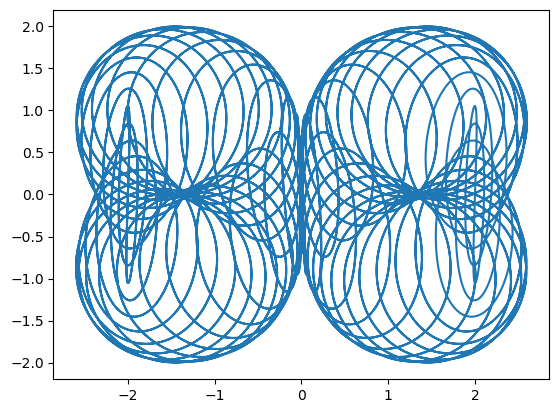

In [15]:
grid = torch.tensor(np.linspace(-6, 6, 10000))

plt.plot(f_1(grid), f_2(grid))

Заметим, что библиотека `matplotlib` справляется с отображением `pytorch`-тензоров, и дополнительных преобразований делать не нужно.



## Вычисление на видеокарте

Если, тензоры в PyTorch и массивы в NumPy так похожи, то зачем нам вообще нужен PyTorch? Для этого надо вспомнить, что нейросети бывают огромных размеров, а проводить операции над большими матрицами вычислетельно дорого. Давайте перемножим две матрицы размером 10000 на 10000 (слои трансформеры в GPT-3 содержат матрицы ещё большего размера):

In [16]:
import time

n = 10000

In [17]:
a = np.ones((n, n))

In [18]:
start = time.time()

np.dot(a, a)

end = time.time() - start

print(end)

14.347854137420654


Вроде бы терпимо. Теперь представьте, что данную операцию надо совершить десятки тысяч раз, и над несколькими матрицами. Уже ставится грустно. Однако, матричные вычисления хорошо распараллеливаются и тут на сцену выходит PyTorch. В нём реализовано распараллеливание вычислений с помощью видеокарт, что позволяет в разы ускорить работу с матрицами в разы

Стандартом является использование видеокарт NVidia и языка CUDA (хотя есть поддержка и других производителей). Для начала вычислений на видеокарте надо перенести на неё тензор, вызвав метод `cuda`:

In [19]:
t = torch.ones((n, n))

device = 'cpu'
t = t.to(device) #переносим тензор на видеокарту

In [20]:
t.device #проверим, что перенеслось

device(type='cpu')

Теперь можно производить вычисления с использованием видеокарты

In [21]:
start = time.time()

torch.mul(t, t)

end = time.time() - start

print(end)

0.06342363357543945


Как видите, ускорение в несколько тысяч раз!

## Дифференцирование



Обучение нейронной сети опирается на алгоритм обратного распространения ошибки, для этого необходимо уметь строить граф вычислений и дифференцировать его. Как вы уже догодались, PyTorch с эти успешно справляется. Посмотрим как это происходит

Установим библиотек для визуализации графа

In [22]:
from torchviz import make_dot

Для того, чтобы добавить тензор к вычислительному графу необходимо при его создании установить параметр `requires_grad=True`. Обратите внимание, что только тензоры вещественных чисел  можно привязать к графу

Построим вычислительный граф для следующей функции

$$f(x, y)=x^2 * y + 10x^{\sin(y)}$$



In [23]:
x = torch.tensor(1, requires_grad=True, dtype=torch.float)
y = torch.tensor(1, requires_grad=True, dtype=torch.float)

In [24]:
f = x ** 2 * y + 10 * x ** torch.sin(y)

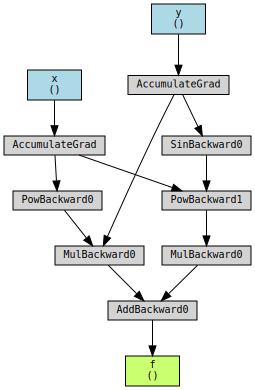

In [25]:
make_dot(f, params={'x': x, 'y': y, 'f': f})

Для того, чтобы посчитать градиент функции по всем параметрам, надо всего лишь вызвать метод `backward`

In [26]:
f.backward()

Получившиеся градиенты являются атрибутами параметров функции. Чтобы посмотреть их надо посмотреть атрибут `grad`

In [27]:
y.grad

tensor(1.)

In [28]:
x.grad

tensor(10.4147)

PyTorch устроен так, что градиенты накапливаются

In [29]:
f = x ** 2 * y + 10 * x ** torch.sin(y)
f.backward()

In [30]:
y.grad

tensor(2.)

In [31]:
x.grad

tensor(20.8294)

Поэтому прежде чем повторять процедуру дифференцирования необходиомо занулить градиенты

In [32]:
x.grad.zero_()
x.grad

tensor(0.)

In [33]:
y.grad.zero_()
y.grad

tensor(0.)

Чтобы отсоеденить тензор от вычислительного графа и перестать накапливать градиенты воспользуйтесь методом `detach()`

In [34]:
x.detach()

tensor(1.)

Чтобы создать копию тензора можно воспользоваться методом `clone()`, при этом склонированный тензор будет присоединён к графу.

In [35]:
a = y.clone()
a

tensor(1., grad_fn=<CloneBackward0>)

**ЗАДАНИЕ 3**

Посчитайте производную функции

$$f(x, y, z)=\frac{x^2 + y^2}{\exp z}$$

по переменной $x$ в точке (1, 1, 0)

In [36]:
x = torch.tensor(1, requires_grad=True, dtype=torch.float)
y = torch.tensor(1, requires_grad=False, dtype=torch.float)
z = torch.tensor(0, requires_grad=False, dtype=torch.float)

In [37]:
f = (x ** 2 + y ** 2) / torch.exp(z)

f.backward()

In [38]:
x.grad

tensor(2.)

## Простой пример обучения нейронной сети

Теперь, можно приступить к самому главному назначению PyTorch и обучить нейросеть


### Цикл обучения модели

Посмотрим на общий процесс обучения. Пусть задана нейронная сеть $f(x)$, параметризуемая обучаемыми параметрами $\theta$. Для входных данных $x$ модель возращает $\widehat{y}=f(x)$. Для обучения модели необходимо задать оптимизируемую функцию (функцию ошибки, лосс) $L(y, \widehat{y})$, которую следует минимизовать.


Процесс обучения задается следующим образом.
 * **Прямой проход / Forward pass:** <br>
     Считаем $\widehat{y}=f(x)$ для входных данных $x$. <br>
 * **Вычисление оптимизируемой функции:**<br>
     Вычисляем оптимизируемую функцию $L(y, \widehat{y})$. <br>
 * **Обратный проход / Backward pass:** <br>
     Считаем градиенты по всем обучаемым параметрам $\frac{\partial L}{\partial \theta}$. <br>
 * **Шаг оптимизации:** <br>
     Делаем шаг градиентного спуска, обновляя все обучаемые параметры. <br>
    

### Линейная регрессия

В лекциях показано, что линейную регрессию можно представить как частный случай нейрона с тождественной функцией активации.

Сделаем одномерную линейную регрессию на датасете <a href="http://lib.stat.cmu.edu/datasets/boston" target="_blank">boston</a>. Этот датасет представляет собой набор данных конца 70-х годов прошлого века для предсказания цены недвижимости в Бостоне.

Скачиваем данные.

In [39]:
def load_boston():
    # ссылка для скачивания данных
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    # собираем таблицу данных
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    # выделяем признаки и таргет
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\korot\AppData\Local\Temp\ipykernel_21052\3633601524.py:5: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [40]:
data, target = load_boston()

Будем рассматривать зависимость таргета, т.е. медианной стоимости домов в тысячах долларов, от последнего признака, т.е. процента населения людей с низким уровнем дохода.

Text(0.5, 1.0, 'Медианная стоимость домов в тыс. $')

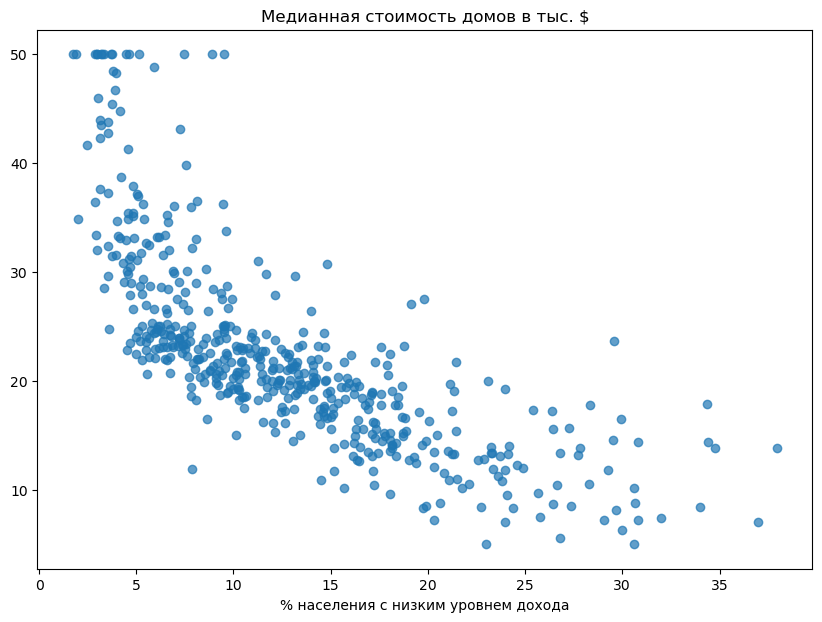

In [41]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:, -1], target, alpha=0.7)
plt.xlabel('% населения с низким уровнем дохода')
plt.title('Медианная стоимость домов в тыс. $')

В данном случае предсказание модели задается следующим образом: $$\widehat{y}(x) = wx + b,$$
где $w, b \in \mathbb{R}$ &mdash; обучаемые параметры модели. Это обычная линейная модель, и с ней мы уже работали <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html" target="_blank">ранее</a>.

Объявляем обучаемые параметры. Также задаем признак $X$ и таргет $Y$ в виде `torch`-тензоров.

In [42]:
# создаем два тензора размера 1 с заполнением нулями,
# для которых будут вычисляться градиенты
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Данные оборачиваем в тензоры, по которым не требуем вычисления градиента
x = torch.FloatTensor(data[:, -1] / 10)
y = torch.FloatTensor(target)

# по-другому:
# x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
# y = torch.tensor(boston.target, dtype=torch.float32)

Зададим оптимизируемую функцию / функцию ошибки / лосс &mdash; <a href="https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html#3.-Тестирование-и-оценка-качества" target="_blank">MSE</a>:

$$
\mathrm{MSE}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n \left(\widehat{y}_i - y_i\right)^2.
$$


In [43]:
def optim_func(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

После того, как мы посчитаем результат применения этой функции к нашим данным, нам необходимо посчитать градиенты по всем обучаемым параметрам, чтобы затем сделать шаг градиентного спуска. В этом нам поможет функция `backward`. Вызвав `backward` для результата подсчета функции ошибки `loss`, мы сделаем обратный проход по всему графу вычислений и посчитаем градиенты лосса по всем обучаемым параметрам.

In [44]:
# Прямой проход
y_pred = w * x + b

# Вычисление лосса
loss = optim_func(y_pred, y)

# Вычисление градиентов
# с помощью обратного прохода по сети
# и сохранение их в памяти сети
loss.backward()

Здесь `loss` &mdash; значение функции MSE, вычисленное на этой итерации.

In [45]:
loss

tensor(592.1469, grad_fn=<MeanBackward0>)

К градиентам для обучаемых параметров, которые требуют градиента (`requires_grad=True`), теперь можно обратиться следующим образом:

In [46]:
print("dL/dw =", w.grad)
print("dL/db =", b.grad)

dL/dw = tensor([-47.3514])
dL/db = tensor([-45.0656])


Если мы посчитаем градиент $M$ раз, то есть $M$ раз вызовем `loss.backward()`, то градиент будет накапливаться (суммироваться) в параметрах, требующих градиента. Иногда это бывает удобно.

Убедимся на примере, что именно так все и работает.

In [47]:
y_pred = w * x + b
loss =  optim_func(y_pred, y)
loss.backward()

print("dL/dw =", w.grad)
print("dL/b =", b.grad)

dL/dw = tensor([-94.7029])
dL/b = tensor([-90.1312])


Видим, что значения градиентов стали в 2 раза больше, за счет того, что мы сложили одни и те же градиенты 2 раза.

Если же мы не хотим, чтобы градиенты суммировались, то нужно **занулять
градиенты** между итерациями после того как сделали шаг градиентного спуска.
Это можно сделать с помощью функции `zero_` для градиентов.

In [48]:
w.grad.zero_()
b.grad.zero_()
w.grad, b.grad

(tensor([0.]), tensor([0.]))

Напишем функцию визуализации процесса обучения.

In [49]:
def show_progress(x, y, y_pred, loss):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Избавимся от градиентов перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число, для красивого отображения
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75)
    plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.xlabel('% населения с низким уровнем дохода')
    plt.title('Медианная стоимость домов в тыс. $')
    plt.show()

    print(f"MSE = {loss:.3f}")

**ЗАДАЧА 4**

Построим нейронную сеть из двух слоев:

$$\widehat{y}(x) = w_2u(x) + b_2,$$

$$u(x) = \sigma(w_1x + b_1),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_2, b_2 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае мы выбрали `ReLU`. Можно заметить, что это функция не удовлетворяет условиям теоремы Цыбенко, тем не менее на практике она часто применяется для нейронных сетей.

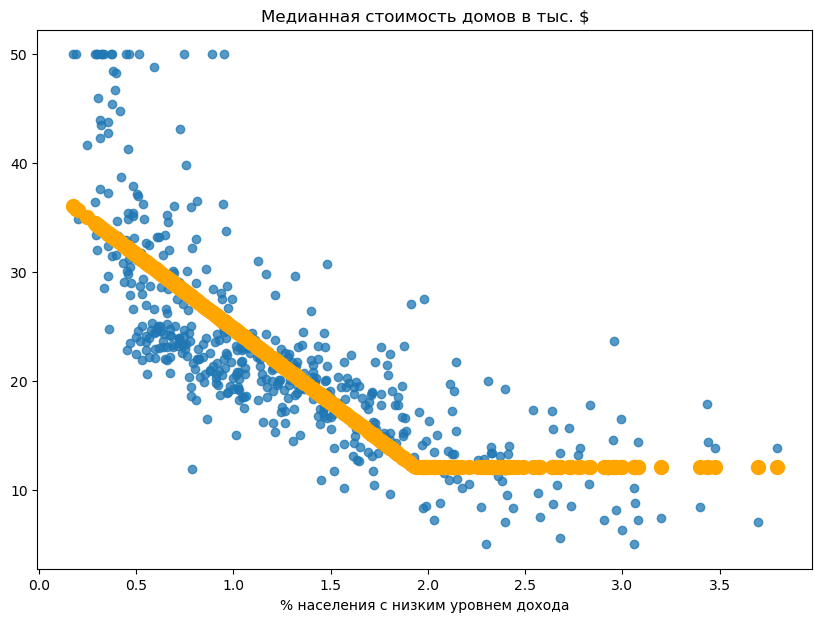

MSE = 32.994
Готово!


In [50]:
# Инициализация параметров
w0 = torch.ones(1, requires_grad=True)
b0 = torch.ones(1, requires_grad=True)
w1 = torch.ones(1, requires_grad=True)
b1 = torch.ones(1, requires_grad=True)

# Функция активации
def act_func(x):
    return x * (x >= 0)

# Количество итераций
num_iter = 1000

# Скорость обучения для параметров
lr_w = 0.01
lr_b = 0.05

for i in range(num_iter):

    # Forward pass: предсказание модели
    y_pred =  act_func(w0 * x + b0) * w1 + b1

    # Вычисление оптимизируемой функции (MSE)
    loss = optim_func(y_pred, y)

    # Bakcward pass: вычисление градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    w0.data -= lr_w * w0.grad
    w1.data -= lr_w * w1.grad
    b0.data -= lr_b * b0.grad
    b1.data -= lr_b * b1.grad

    # Зануление градиентов
    w0.grad.zero_()
    w1.grad.zero_()
    b0.grad.zero_()
    b1.grad.zero_()

    # График + вывод MSE через каждые 5 итераций
    if (i + 1) % 5 == 0:
        show_progress(x, y, y_pred, loss)

        if loss.item() < 33:
            print("Готово!")
            break



# Готовые модули из PyTorch



Для ознакомления с высокоуровневым интерфейсом будем решать задачу классификации картинок на 10 классов на датасете CIFAR10 из 60k картинок размера 3x32x32.

Скачаем картинки и посмотрим на них:

In [51]:
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test
    

In [52]:
%%time
# from cifar import load_cifar10

X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array([
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
])

print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(40000, 3, 32, 32) (40000,)
CPU times: total: 469 ms
Wall time: 1.4 s


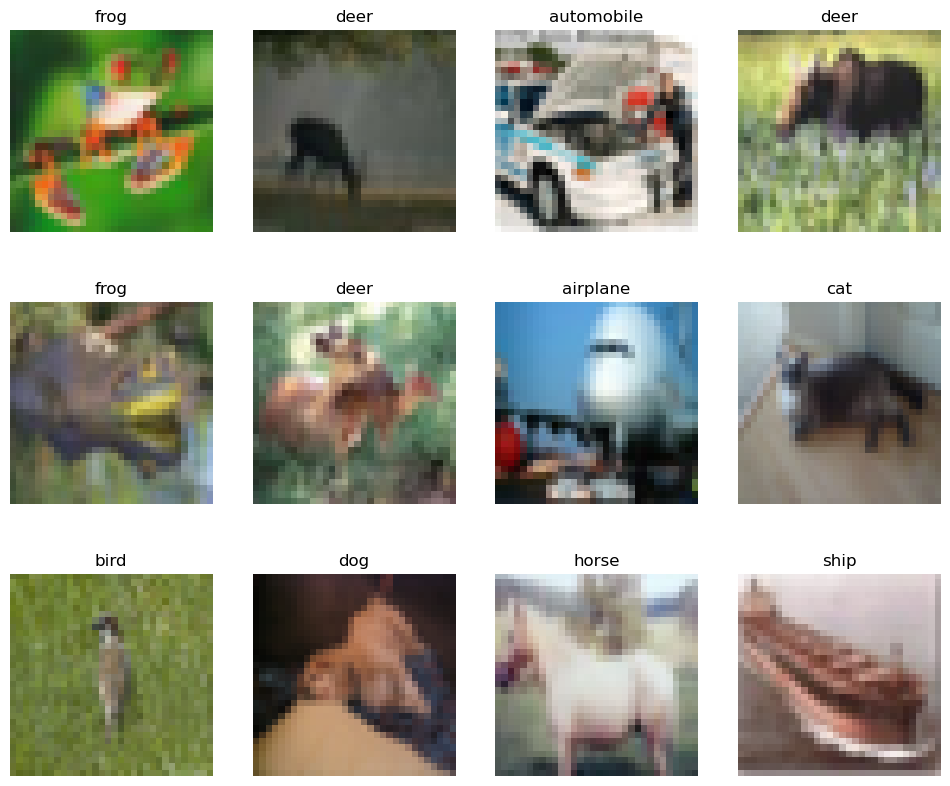

In [53]:
plt.figure(figsize=(12, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.title(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1, 2, 0]))

Обучение проходит по батчам. Поэтому нам нужно либо самим написать генератор для батчей, либо использовать уже написанный за нас класс `DataLoader`. `DataLoader` принимает в аргументах размер батча и также ему можно сказать, нужно ли перемешивать данные. Пока что сами напишем генератор:

In [54]:
def batch_generator(X, y, batchsize, device, shuffle=True):
    '''
        Генерирует tuple из батча объектов и их меток
        X: np.ndarray -- выборка
        y: np.ndarray -- таргет
        batchsize: int -- размер батча
        device: str -- утсройство, на котором будут производиться вычисления
        shuffle: bool -- перемешивать выборку или нет
    '''

    indices = np.arange(len(X))

    # Во время обучения перемешиваем, во время тестирования - нет
    if shuffle:
        indices = np.random.permutation(indices)

    # Идем по всем данным с шагом batchsize.
    # Возвращаем start: start + batchsize объектов на каждой итерации
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]

        # Переведем массивы в соотв. тензоры.
        # Для удобства переместим выборку на наше устройство (GPU).
        yield torch.FloatTensor(X[ix]).to(device), torch.LongTensor(y[ix]).to(device)

Главной абстракцией в PyTorch является `torch.nn.Module`.  
По сути модуль можно понимать как нейронную сеть или ее какую-то часть. Каждый стандартный слой в PyTorch-е наследуются от `torch.nn.Module`.

Модуль это нечто, что имеет метод `forward` и, возможно, `backward`. Но вообще `backward` является автоматическим (`autograd`).  Кроме того, модуль может содержать в себе другие модули.

In [55]:
print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

Часто, когда нейронная сеть не слишком сложная и последовательная, удобно пользоваться `nn.Sequential()` &mdash; последовательный контейнер из модулей. Модули, входящие в этот контейнер будут выполнятся последовательно один за другим, то есть выход одного подается на вход следующему.

Теперь напишем саму модель, которая
будет возвращать **логиты (logits)**. Логиты - это то, что получается **до применения SoftMax** для получения вероятностей в интервале 0-1. Они были у вас в логистической регрессии.

In [56]:
# Создаем последовательную нейронную сеть
model = nn.Sequential()

# Преобразуем входной тензор размера batch_size x n1 x n2 x ... x nm
# к виду batch_size x n, где  n = n1 x n2 x ... x nm
model.add_module('flatten', nn.Flatten())

# Добавляем линейный слой с выходным размером 64.
# Размер входа равен произведению размерностей данных.
model.add_module('linear_1', nn.Linear(3 * 32 * 32, 64))

# Добавляем функцию активации ReLU
model.add_module('relu', nn.ReLU())

# Добавляем еще 1 линейный слой с выходным размером 10,
# равным количеству классов, на выходе получаем логиты
model.add_module('linear_2', nn.Linear(64, 10))

In [57]:
# По-другому с именами слоев
model = nn.Sequential(OrderedDict([
    ('flatten', nn.Flatten()),
    ('linear_1', nn.Linear(3 * 32 * 32, 64)),
    ('relu', nn.ReLU()),
    ('linear_2', nn.Linear(64, 10))
]))



In [58]:
# По-другому без имен слоев
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),  # 3072 x 64
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [59]:
model.cpu()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)

*Примечание:* Если вы используете имена для слоев при создании контейнера, то имена должны быть разными, иначе при встрече слоя с уже существующим именем, предыдущий слой с таким именем будет перезаписан на новый.

У полученной модели можно посмотреть на все ее обучаемые параметры : `model.parameters()`

In [60]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([64, 3072]), torch.Size([64]), torch.Size([10, 64]), torch.Size([10])]


Мы создали модель, то есть научились по какому-либо входу получать выход модели. Чтобы обучить данную модель, нам нужно минимизировать эмпирический риск, то есть функцию потерь ("лосс"). Для этого определим его.

### Объявление функции потерь (лосса)

Для разных задач необходимо использовать разные функции потерь.

Пусть $n$ &mdash; размер выборки.
- `LogLoss / BinaryCrossEntropy / BCE`: *бинарная классификация*.  
Пусть $\widehat{y_i} \in (0,1), y \in \{0,1\}$, тогда
$$
\mathcal{L}(\widehat{y}, y) = -\frac{1}{n} \sum_{i = 1}^n \Big[ y_i \log{\widehat{y}_i} + (1 - y_i) \log{(1 - \widehat{y}_i)}\Big]
$$
Обратите внимание, что в `pytorch` присутствует два варианта реализации этого лосса `BCELoss` и `BCEWithLogitsLoss`. Первый вариант принимает на вход предсказанную вероятность класса 1 (т. е. выход сети после применения сигмоиды), второй же - логит (т. е. выход сети до применения сигмоиды, а преобразование делается внутри). Второй вариант является более вычислительно стабильным.

- `CrossEntropy`: *многоклассовая классификация*.  
Пусть $\widehat{y}_{ij} \in (0,1)^n, y_{ij} \in \{0,1\}^n$, $K$ $-$ количество классов, тогда
$$
\mathcal{L}(\widehat{y}, y) = -\frac{1}{n} \sum_{i = 1}^n  \sum_{j=1}^K y_{ij} \log\widehat{y}_{ij}
$$
- `MSELoss`: *регрессия*  
Пусть $\widehat{y}, y \in \mathbb{R}$, тогда
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{n} \sum_{i = 1}^n  (\widehat{y}-y)^2
$$

Мы имеем дело с многоклассовой классификацией, поэтому берем CrossEntropy.

In [61]:
criterion = nn.CrossEntropyLoss()

###  Подбираем оптимизатор

В `torch.optim` лежит много разных уже готовых оптимизаторов таких как SGD, RMSprop, Adam и прочие. О них мы поговорим подробнее на следующей лекции.

Оптимизатор принимает набор тензоров, по которым он будет считать градиенты и которые будет оптимизировать. Обычно это все параметры модели поэтому обычно передаем `model.parameters()`. <br>
Сначала нам нужно сделать обратный проход посчитав все градиенты, потом мы делаем шаг и уже в конце зануляем градиенты.

In [62]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# loss.backward()      # обратный проход, считаем градиенты
# opt.step()           # делаем шаг градиентного спуска
# opt.zero_grad()      # зануляем градиенты

Теперь у нас все готово для обучения.

В фазе обучения мы вызываем метод `train(True)` у модели, чтобы перевести ее в фазу обучения: `model.train(True)`. В фазе тестирования ставим `model.train(False)` или `model.eval()`.
Это влияет на:
- поведение Dropout слоев
- поведение BatchNorm слоев

Сейчас эти слои мы не используем, но уже держим это в голове.

В фазе тестирования будем использовать контекстный менеджр `torch.no_grad`, который отключает возможность подсчета градиентов. Это позволяет более экономно использовать память.

По ходу обучения будем сохранять лучшую модель по метрике на валидации. Это просто делается с помощью метода `torch.save`. Рекомендуется сохранять не сам класс модели, а ее состояние (значения параметров). Подробности можно посмотреть [здесь](https://pytorch.org/tutorials/beginner/saving_loading_models.html).  Выгрузить модель можно с помощью метода `torch.load()`.



In [63]:
num_epochs = 100  # общее кол-во полных проходов ("эпох") по обучаемым данным
batch_size = 64  # кол-во объектов в одном батче

num_train_batches = len(X_train) // batch_size
num_val_batches = len(X_val) // batch_size

history = defaultdict(lambda: defaultdict(list))

best_val_acc = 0.

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    start_time = time.time()

    # Устанавливаем поведение dropout / batch_norm  в обучение
    model.train(True)

    # На каждой "эпохе" делаем полный проход по данным
    for X_batch, y_batch in batch_generator(X_train, y_train, batch_size, device=device):

        # Обучаемся на батче (одна "итерация" обучения нейросети)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        # Обратный проход, шаг оптимизатора и зануление градиентов
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Используйте методы тензоров:
        # detach -- для отключения подсчета градиентов
        # cpu -- для перехода на cpu
        # numpy -- чтобы получить numpy массив
        train_loss += loss.detach().cpu().numpy()
        y_pred_np = np.argmax(logits.detach().cpu().numpy(), axis=1)
        y_batch_np = y_batch.cpu().numpy()
        train_acc += (y_batch_np == y_pred_np).sum()

    # Подсчитываем лоссы и сохраням в "историю"
    train_loss /= num_train_batches
    train_acc /= num_train_batches * batch_size
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)

    # Устанавливаем поведение dropout / batch_norm  в тестирование
    model.eval()

    # Полный проход по валидации
    with torch.no_grad(): # Отключаем подсчет градиентов, то есть detach не нужен
        for X_batch, y_batch in batch_generator(X_val, y_val, batch_size, device=device):
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            val_loss += loss.cpu().numpy().sum()
            y_pred_np = np.argmax(logits.cpu().numpy(), axis=1)
            y_batch_np = y_batch.cpu().numpy()
            val_acc += (y_batch_np == y_pred_np).sum()

    # Подсчитываем лоссы и сохраням в "историю"
    val_loss /= num_val_batches
    val_acc /= num_val_batches * batch_size
    history['loss']['val'].append(val_loss)
    history['acc']['val'].append(val_acc)

    # Сохраняем лучшую модель по метрике на валидации
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), 'first_model.pth')

    # Печатаем результаты после каждой эпохи
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

Epoch 1 of 100 took 0.878s
  training loss (in-iteration): 	2.056322
  validation loss (in-iteration): 	1.916733
  training accuracy: 			26.70 %
  validation accuracy: 			32.44 %
Epoch 2 of 100 took 0.956s
  training loss (in-iteration): 	1.879302
  validation loss (in-iteration): 	1.846726
  training accuracy: 			33.93 %
  validation accuracy: 			35.48 %
Epoch 3 of 100 took 0.878s
  training loss (in-iteration): 	1.813687
  validation loss (in-iteration): 	1.773776
  training accuracy: 			36.23 %
  validation accuracy: 			38.03 %
Epoch 4 of 100 took 0.856s
  training loss (in-iteration): 	1.767003
  validation loss (in-iteration): 	1.742510
  training accuracy: 			38.09 %
  validation accuracy: 			38.96 %
Epoch 5 of 100 took 0.978s
  training loss (in-iteration): 	1.730008
  validation loss (in-iteration): 	1.713319
  training accuracy: 			39.66 %
  validation accuracy: 			40.37 %
Epoch 6 of 100 took 0.954s
  training loss (in-iteration): 	1.699795
  validation loss (in-iteration): 	1

Построим кривые обучения (learning curves):

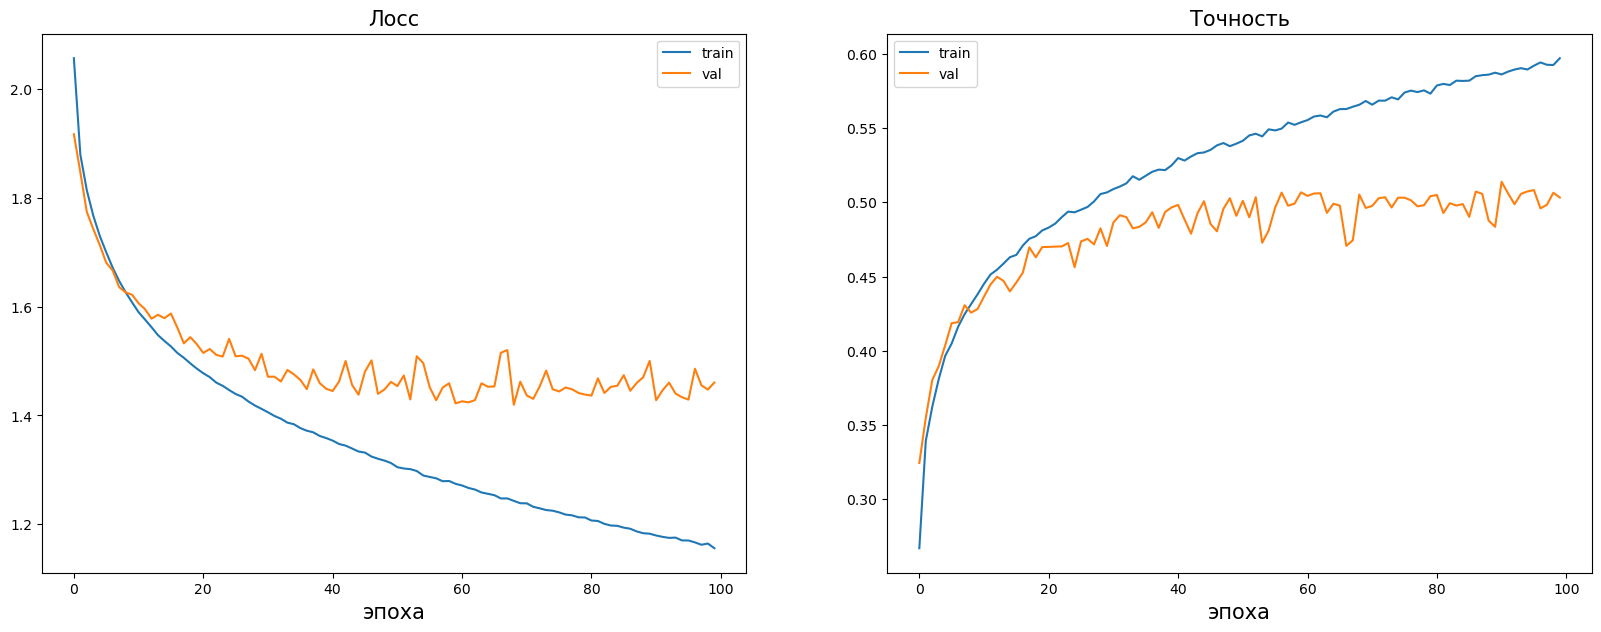

In [64]:
fig = plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Лосс', fontsize=15)
plt.plot(history['loss']['train'], label='train')
plt.plot(history['loss']['val'], label='val')
plt.xlabel('эпоха', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.title('Точность', fontsize=15)
plt.plot(history['acc']['train'], label='train')
plt.plot(history['acc']['val'], label='val')
plt.xlabel('эпоха', fontsize=15)
plt.legend();

**Заметки**
* Не забывайте **занулять градиенты** после каждой итерации.
* Если ваш loss стал `nan`/`inf`, то повыводите то, что происходит на каждой итерации и поймите в каком именно месте проблема.
* Если ваш loss уменьшался, а потом стал равен `nan`, то попробуйте уменьшить `learning rate`.

Сделаем аналогичную модель, только с 3 слоями, вместо 2, и в виде модуля, а не Sequential-модели. Заметим, что здесь наша модель - это модуль, который наследуется от `nn.Module` и содержит в себе другие модули, такие как `nn.Linear`.

Как было сказано выше, модуль должен обязательно иметь метод `forward()`, который мы сами определяем. Метод `backward()`является необязательным, PyTorch сможет сам понять, что делать при обратном проходе.

In [65]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [66]:
###### 1. Обернем цикл обучения нейросети в отдельную функцию ######

def train(
    model,
    criterion,
    optimizer,
    X_train, y_train,
    X_val, y_val,
    num_epochs=100,
    batch_size=64,
    model_path='model.pth'
):
    """
    # Обучение модели
    """

    num_train_batches = len(X_train) // batch_size
    num_val_batches = len(X_val) // batch_size

    history = defaultdict(lambda: defaultdict(list))

    best_val_acc = 0.

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        model.train(True)  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in batch_generator(X_train, y_train, batch_size, device=device):

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach().cpu().numpy()
            y_pred_np = np.argmax(logits.detach().cpu().numpy(), axis=1)
            y_batch_np = y_batch.cpu().numpy()
            train_acc += (y_batch_np == y_pred_np).sum()

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= num_train_batches
        train_acc /= num_train_batches * batch_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in batch_generator(X_val, y_val, batch_size, device=device):
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.cpu().numpy()
                y_pred_np = np.argmax(logits.cpu().numpy(), axis=1)
                y_batch_np = y_batch.cpu().numpy()
                val_acc += (y_batch_np == y_pred_np).sum()

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= num_val_batches
        val_acc /= num_val_batches * batch_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), model_path)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return model, history

In [67]:
###### 2. Обернем построение графиков в отдельную функцию    ######

def plot_learning_curves(history):
    """
    Построение графиков
    """
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

In [68]:
###### 3. Обучим модель в Functional-стиле на CIFAR10     ######

model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    X_train, y_train,
    X_val, y_val,
    num_epochs=100,
    batch_size=50,
    model_path='simple_model.pth'
)

Epoch 1 of 100 took 2.613s
  training loss (in-iteration): 	2.116666
  validation loss (in-iteration): 	1.945815
  training accuracy: 			23.20 %
  validation accuracy: 			30.45 %
Epoch 2 of 100 took 2.387s
  training loss (in-iteration): 	1.908124
  validation loss (in-iteration): 	1.832900
  training accuracy: 			32.00 %
  validation accuracy: 			35.51 %
Epoch 3 of 100 took 2.267s
  training loss (in-iteration): 	1.831255
  validation loss (in-iteration): 	1.790595
  training accuracy: 			35.01 %
  validation accuracy: 			36.23 %
Epoch 4 of 100 took 2.200s
  training loss (in-iteration): 	1.774076
  validation loss (in-iteration): 	1.728500
  training accuracy: 			36.85 %
  validation accuracy: 			38.00 %
Epoch 5 of 100 took 2.301s
  training loss (in-iteration): 	1.721015
  validation loss (in-iteration): 	1.682006
  training accuracy: 			38.98 %
  validation accuracy: 			39.92 %
Epoch 6 of 100 took 2.165s
  training loss (in-iteration): 	1.677720
  validation loss (in-iteration): 	1

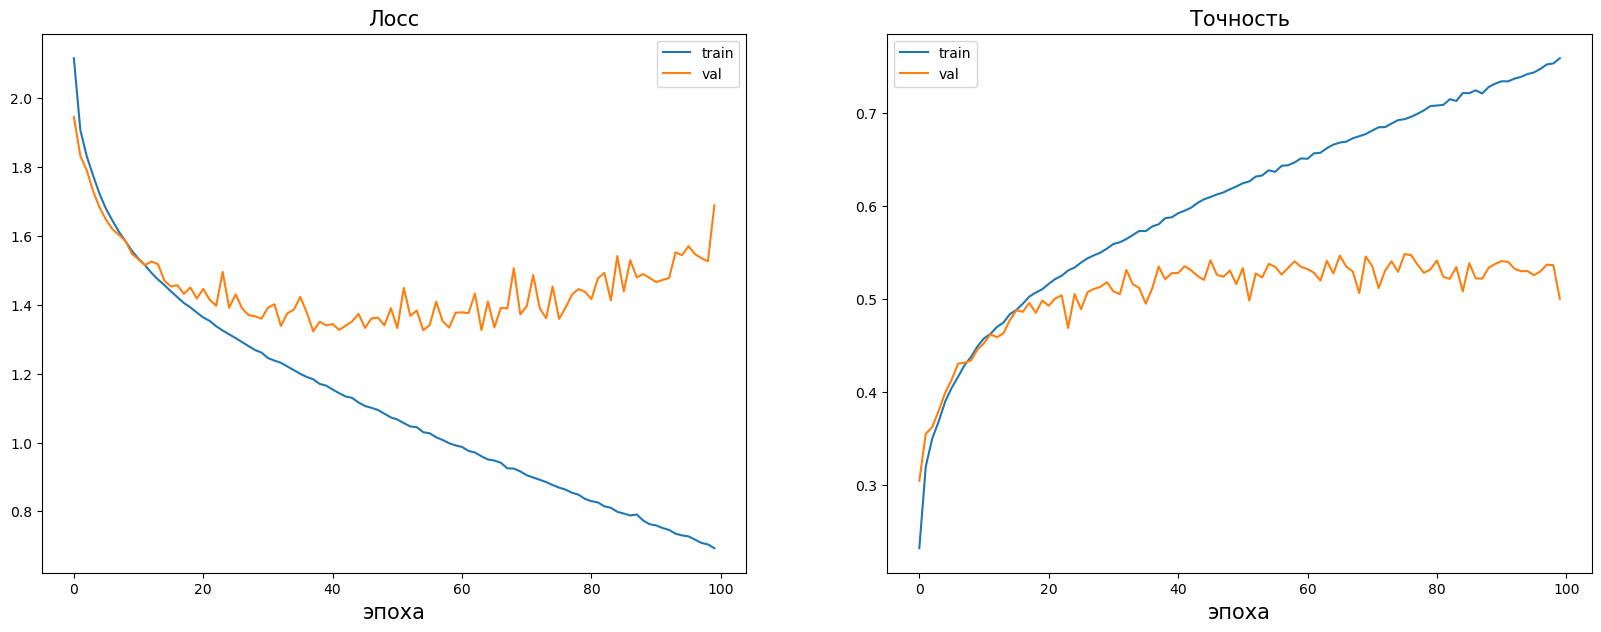

In [69]:
plot_learning_curves(history)

Теперь рассмотрим как получить генератор батчей методами PyTorch. Как ранее уже упоминалось, для этого используется `DataLoader`

```
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,  
           batch_sampler=None, num_workers=0, collate_fn=None,  
           pin_memory=False, drop_last=False, timeout=0,  
           worker_init_fn=None, *, prefetch_factor=2,  
           persistent_workers=False)
```
Рассмотрим параметры, которые нам сейчас пригодятся.
* `dataset` &mdash; датасет, на котором будет построен итератор. Каким он должен быть, будет пояснено далее.

* `batch_size` &mdash; размер батча.

* `shuffle` &mdash; стоит ли перемешивать данные до разделения на батчи. Параметр имеет смысл, если не указан способ семплирования с помощью параметров `sampler` или `batch_sampler`. Если параметр задан как `True`, то выборка будет перемешана заново до наступления нового цикла итерирования. При этом батчи будут выбираться последовательно из перемешанной выборки.

* `num_workers` &mdash; с помощью этого параметра можно установить параллельную загрузку данных. Он обозначает количество процессов, которые будут запущены в мульти-процессорном режиме.

Как мы видим, для `DataLoader` нужен еще `dataset`. Это может быть map-style или iterable датасет. Мы зададим iterable. Для этого мы создадим класс, у которого есть методы `__getitem__` и `__len__`.
  

In [70]:
class SimpleDataset():
    """
    Простой итерируемый датасет.
    """
    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data

    def __len__(self):
        """
        Размер датасета.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().astype(np.float32)
        yi = self.y[idx].astype(np.longlong)
        return xi, yi

Инициализируем датасеты и итераторы.

In [71]:
from torch.utils.data import DataLoader

In [72]:
# Обучающий и валидационный датасеты
train_dataset = SimpleDataset(X_train, y_train)
val_dataset = SimpleDataset(X_val, y_val)

# Размер батча
batch_size = 32

# Количество процессов в dataloader
num_workers = 2

# Обучающий и валидационный генераторы данных
train_loader = DataLoader(
    train_dataset, batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset, batch_size,
    shuffle=False,
)

Проверим, что все работает. `DataLoader` сам привел NumPy массивы к PyTorch тензорам.

In [73]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 3072]), torch.Size([32]))

Запишем цикл обучения в виде функции.

In [74]:
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    checkpoint_path='model.pt',
):
    """
    # Обучение модели
    """
    start_time = time.time()

    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, axis=1).detach()
            train_acc += (y_batch == y_pred).sum()
            train_size += len(y_batch)

        # Подсчитываем лоссы и точность, сохраняем в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.detach() * len(y_batch)
                y_pred = torch.argmax(logits, axis=1).detach()
                val_acc += (y_batch == y_pred).sum()
                val_size += len(y_batch)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss = val_loss.cpu().numpy() / val_size
        val_acc = val_acc.cpu().numpy() / val_size
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # Сохраняем лучшую модель по метрике на валидации
        if val_acc > best_val_acc:
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Эпоха {} из {}, время {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time
        ))
        print("  loss на обучении (на итерации): \t{:.6f}".format(train_loss))
        print("  loss на валидации (на итерации): \t{:.6f}".format(val_loss))
        print("  accuracy на обучении: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  accuracy на валидации: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

**ЗАДАНИЕ 5**

Поменяйте функцию активации поcле первого слоя на любую другую

In [75]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Tanh()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

Обучите модель.

In [76]:
model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

history = train(
    model, criterion, optimizer,
    train_loader,
    val_loader,
    num_epochs=100,
    device=torch.device('cpu'),
)

Эпоха 100 из 100, время 407.602s
  loss на обучении (на итерации): 	0.664361
  loss на валидации (на итерации): 	1.587585
  accuracy на обучении: 			76.53 %
  accuracy на валидации: 			52.78 %


Оцените качество

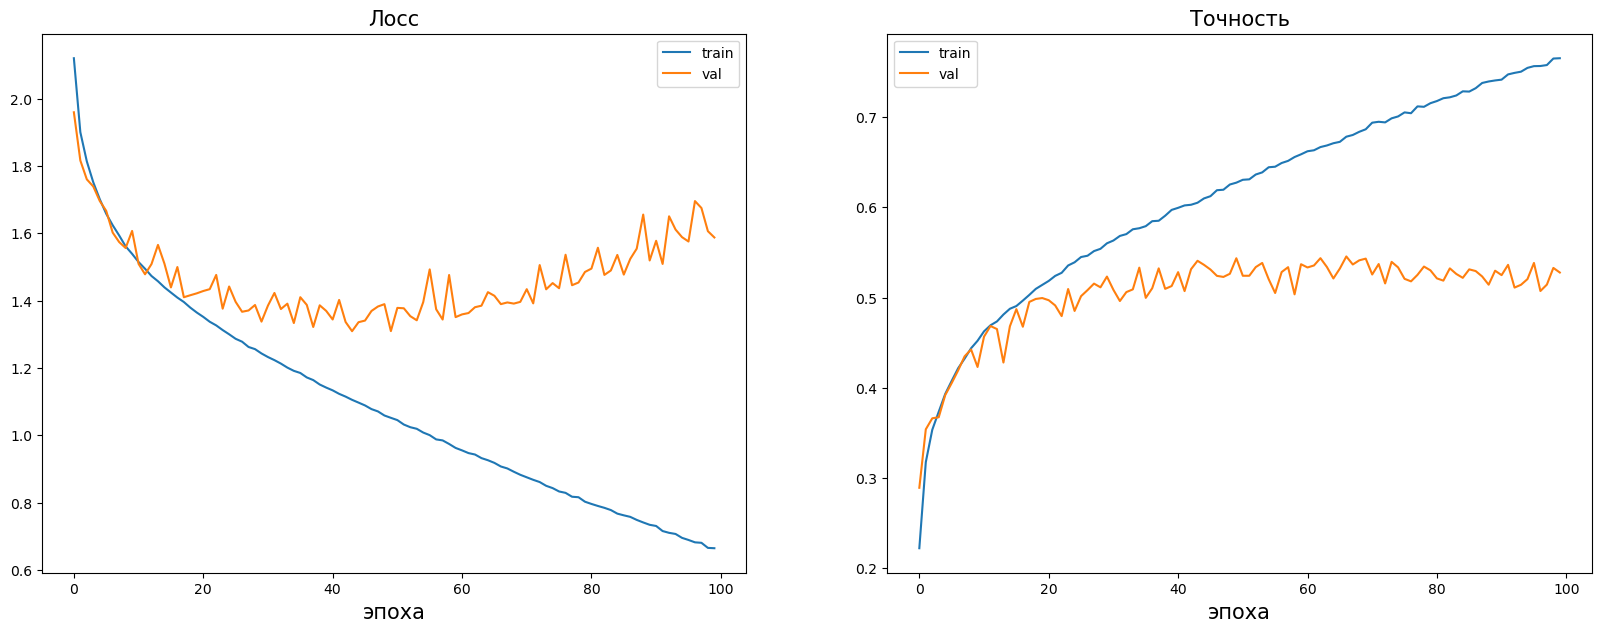

In [77]:
plot_learning_curves(history)

Что изменилось в процессе обучения? Стало ли предсказание лучше?

Заменил Flatten на Tanh Ничего особо не поменялось, предсказание осталось почти таким же


**ЗАДАНИЕ 6**


Измените количество признаков на скрытом слое

In [78]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 32)
        self.linear2 = nn.Linear(32, 8)
        self.linear3 = nn.Linear(8, 10)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Tanh()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

Обучите модель.

In [79]:
model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

history = train(
    model, criterion, optimizer,
    train_loader,
    val_loader,
    num_epochs=100,
    device=torch.device('cpu'),
)

Эпоха 100 из 100, время 245.217s
  loss на обучении (на итерации): 	1.279324
  loss на валидации (на итерации): 	1.489817
  accuracy на обучении: 			54.19 %
  accuracy на валидации: 			47.35 %


Оцените качество

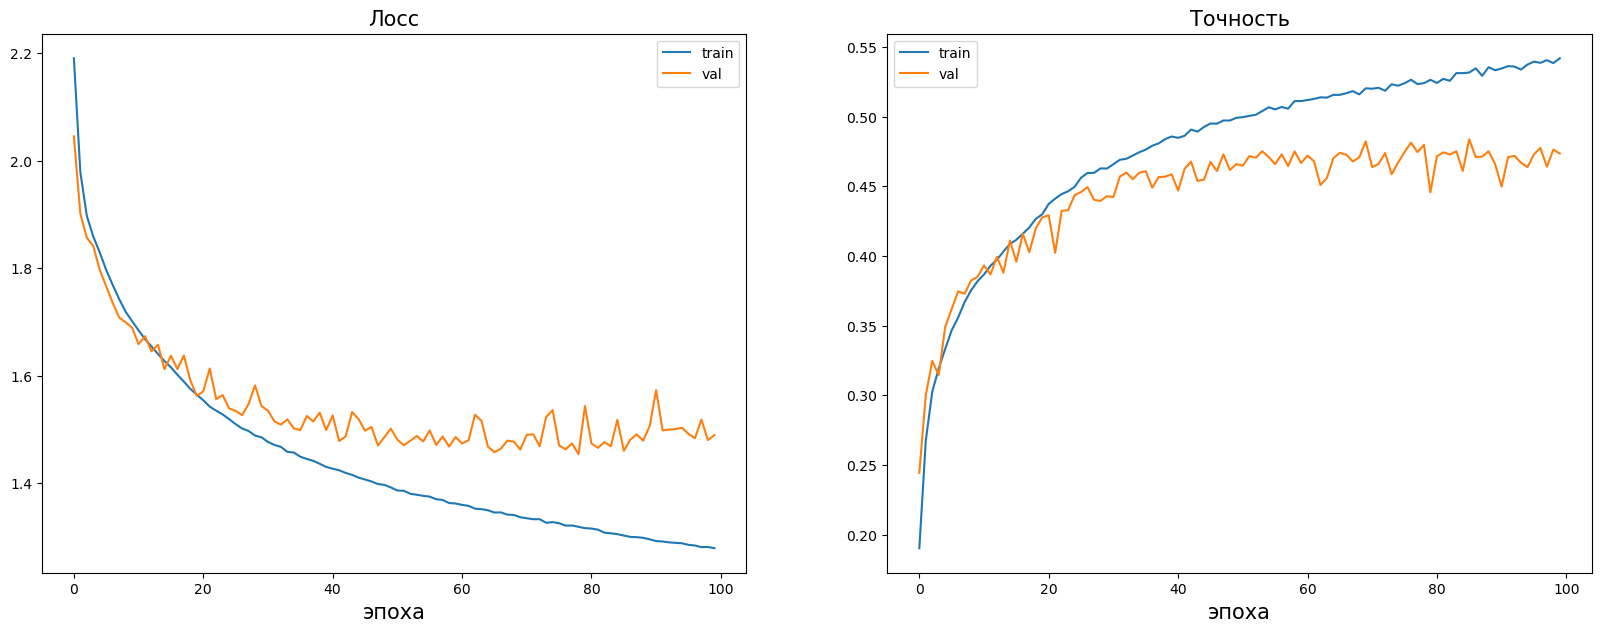

In [80]:
plot_learning_curves(history)

С чем может быть связано изменение качества?

# DropOut

Исключение или дропаут (от англ. dropout) — метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения.

Термин «dropout» (выбивание, выбрасывание) характеризует исключение определённого процента (например 30 %) случайных нейронов (находящихся как в скрытых, так и видимых слоях) на разных итерациях (эпохах) во время обучения нейронной сети. Это очень эффективный способ усреднения моделей внутри нейронной сети. В результате более обученные нейроны получают в сети больший вес. Такой приём значительно увеличивает скорость обучения, качество обучения на тренировочных данных, а также повышает качество предсказаний модели на новых тестовых данных.

После выключения какого-то процента нейронов слоя, неоюодимо перенормировать выходы этого слоя, поделив их на вероятность дропаута, чтобы сохранить распределение выходов. На инференсе ничего делать не надо, так как активированы все нейроны

Как вы уже догадываетесь, PyTorch все реализовал за нас. Для применения дропаута нужно дабавить слой `nn.Dropout()` в вашу модель.

**ЗАДАНИЕ 7**

Обучите сеть при разных значениях вероятности отключения нейронов (не менее 3 разных значений). Попробуйте улучшить имеющийся результат. Объясните полученные вами значения.

In [81]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 32)
        nn.Dropout(0.1)
        self.linear2 = nn.Linear(32, 8)
        nn.Dropout(0.1)
        self.linear3 = nn.Linear(8, 10)
        nn.Dropout(0.1)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Tanh()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [82]:
model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

history = train(
    model, criterion, optimizer,
    train_loader,
    val_loader,
    num_epochs=25,
    device=torch.device('cpu'),
)

Эпоха 25 из 25, время 60.237s
  loss на обучении (на итерации): 	1.505287
  loss на валидации (на итерации): 	1.526227
  accuracy на обучении: 			45.63 %
  accuracy на валидации: 			44.97 %


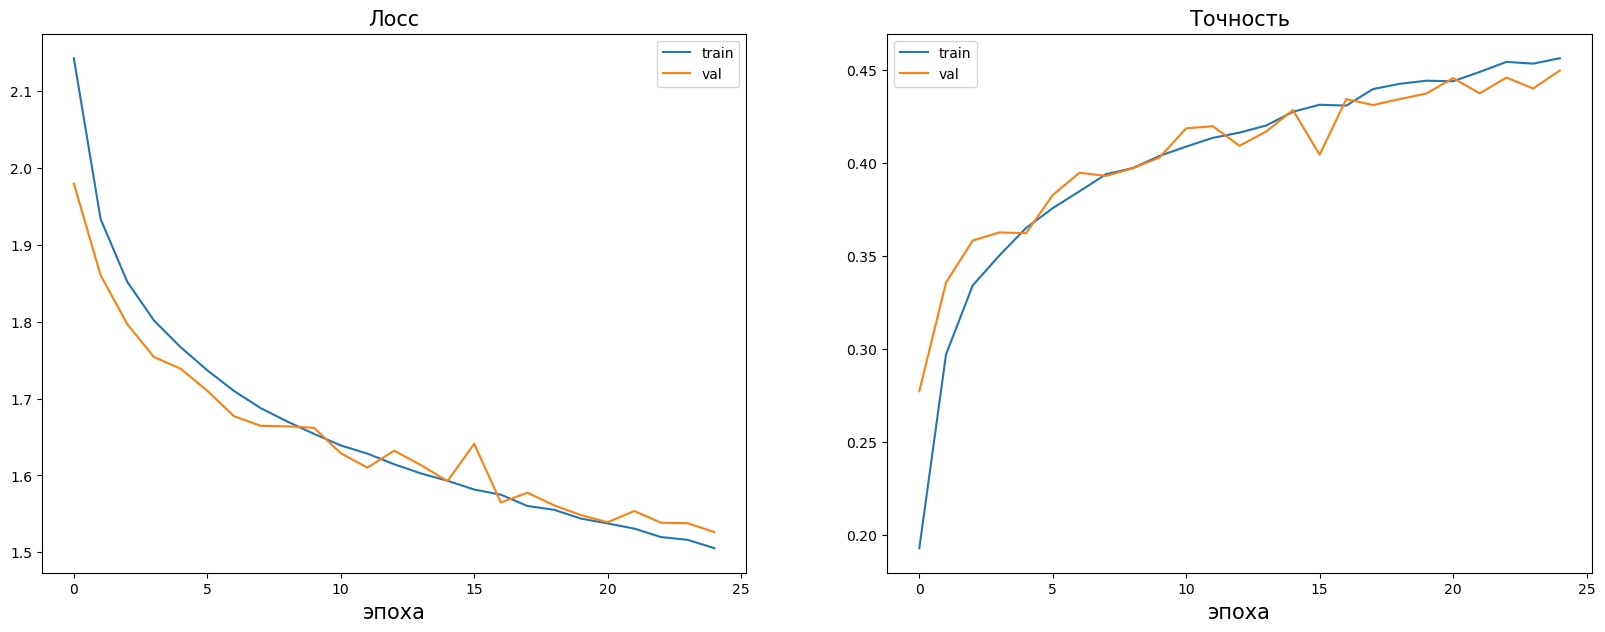

In [83]:
plot_learning_curves(history)

In [84]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 32)
        nn.Dropout(0.3)
        self.linear2 = nn.Linear(32, 8)
        nn.Dropout(0.3)
        self.linear3 = nn.Linear(8, 10)
        nn.Dropout(0.3)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Tanh()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [85]:
model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

history = train(
    model, criterion, optimizer,
    train_loader,
    val_loader,
    num_epochs=25,
    device=torch.device('cpu'),
)

Эпоха 25 из 25, время 67.910s
  loss на обучении (на итерации): 	1.509826
  loss на валидации (на итерации): 	1.544423
  accuracy на обучении: 			45.97 %
  accuracy на валидации: 			43.97 %


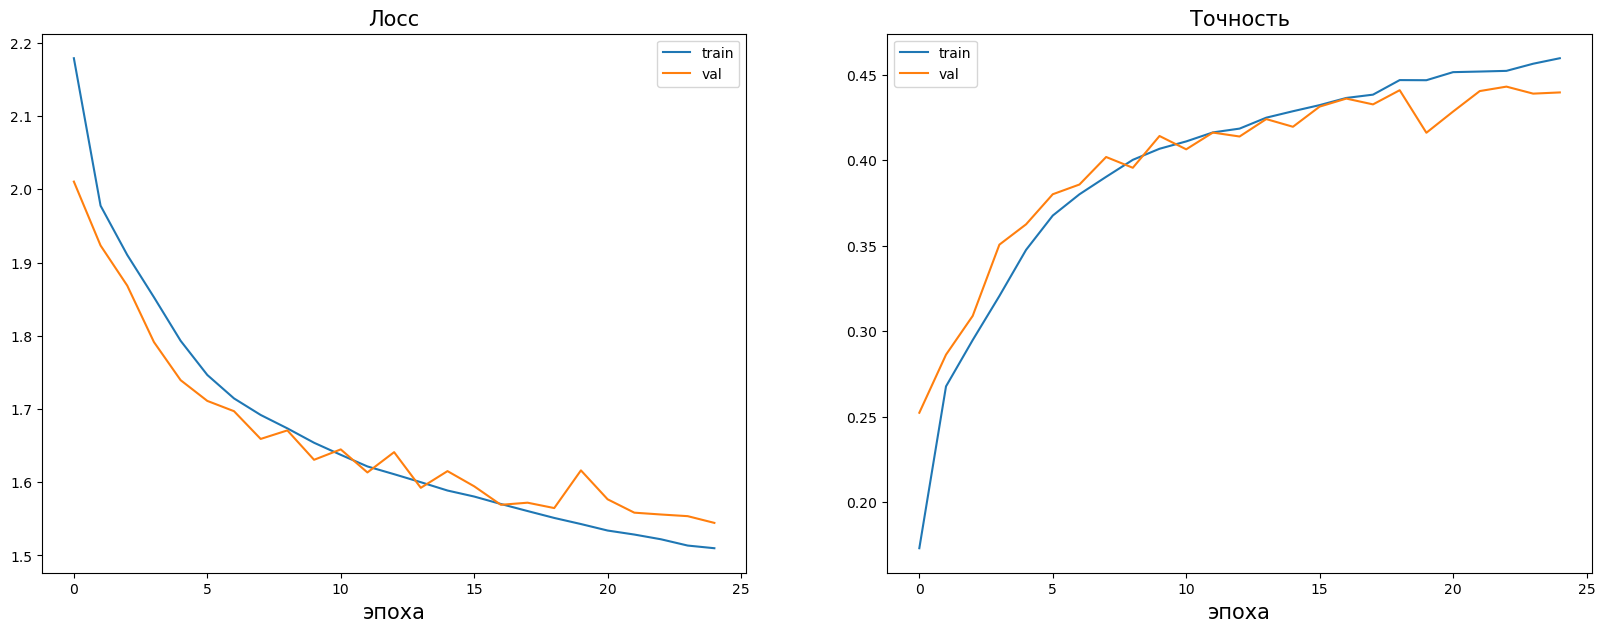

In [86]:
plot_learning_curves(history)

In [87]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''
        super(MySimpleModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 32)
        nn.Dropout(0.6)
        self.linear2 = nn.Linear(32, 8)
        nn.Dropout(0.6)
        self.linear3 = nn.Linear(8, 10)
        nn.Dropout(0.6)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        x = self.linear1(nn.Tanh()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

In [88]:
model = MySimpleModel().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

history = train(
    model, criterion, optimizer,
    train_loader,
    val_loader,
    num_epochs=25,
    device=torch.device('cpu'),
)

Эпоха 25 из 25, время 70.653s
  loss на обучении (на итерации): 	1.481254
  loss на валидации (на итерации): 	1.547260
  accuracy на обучении: 			46.82 %
  accuracy на валидации: 			44.42 %


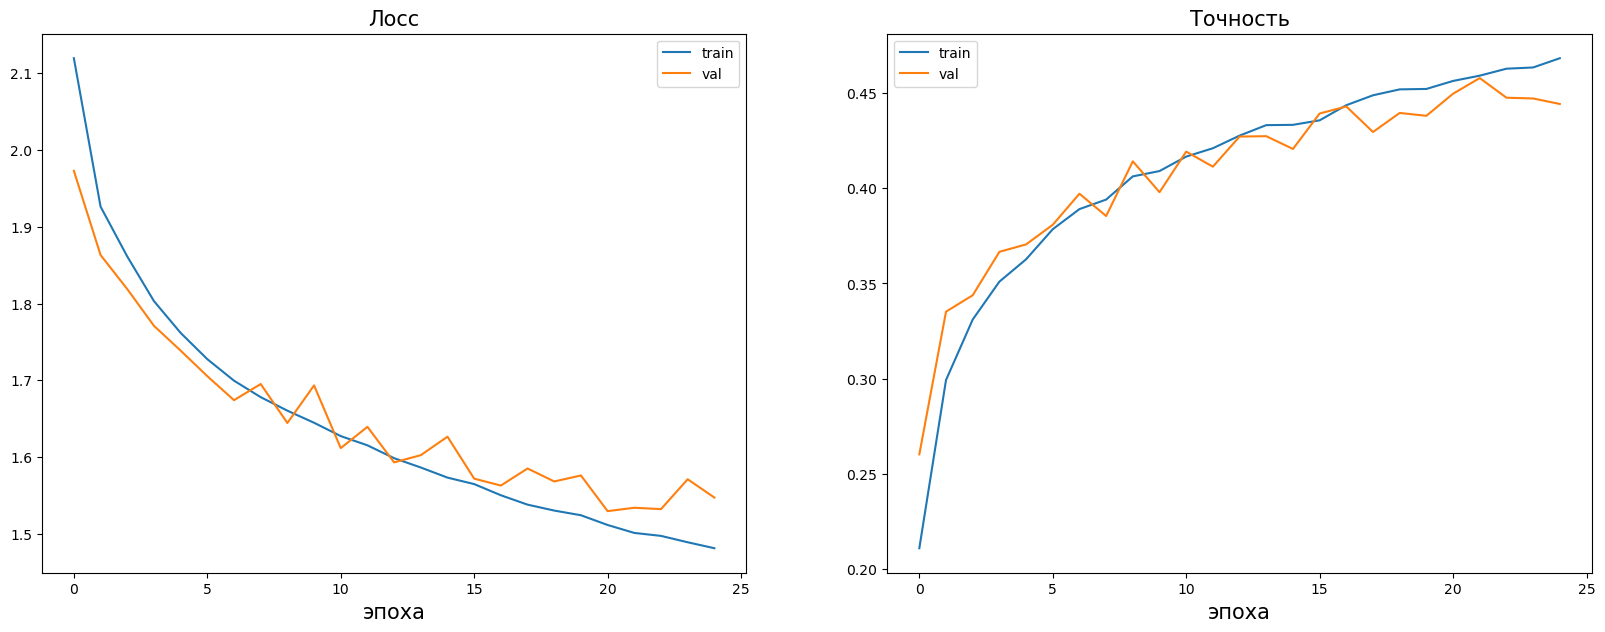

In [89]:
plot_learning_curves(history)